In [ ]:
# Inicializamos GIT
!git init

In [ ]:
# Creamos y activamos el entorno virtual
!python -m venv env
!source env/bin/activate

In [ ]:
# Instalamos las líbrerías necesarias
!pip install requests
!pip install pandas
!pip install bs4
!pip install matplotlib
!pip install Seaborn
!pip install Bokeh

In [ ]:
# Creamos el requirements.txt
!pip freeze > requirements.txt

In [1]:
# Debemos crear el repo en GitHub

In [2]:
# Creamos el archivo main.py, con el siguiente código.
import requests
from bs4 import BeautifulSoup as bs
import pandas as pd

url_csv = "https://api.covidtracking.com/v1/states/daily.csv"
url_json = "https://api.covidtracking.com/v1/states/daily.json"

hist_covid = requests.get(url_json)
awnser_code = hist_covid.status_code
json_covid = hist_covid.json()

frames = pd.DataFrame(json_covid)
print(frames)

soup_covid = bs(hist_covid.text, features="html.parser")

           date state  positive  probableCases   negative  pending  \
0      20210307    AK   56886.0            NaN        NaN      NaN   
1      20210307    AL  499819.0       107742.0  1931711.0      NaN   
2      20210307    AR  324818.0        69092.0  2480716.0      NaN   
3      20210307    AS       0.0            NaN     2140.0      NaN   
4      20210307    AZ  826454.0        56519.0  3073010.0      NaN   
...         ...   ...       ...            ...        ...      ...   
20775  20200117    WA       0.0            NaN        NaN      NaN   
20776  20200116    WA       0.0            NaN        NaN      NaN   
20777  20200115    WA       0.0            NaN        NaN      NaN   
20778  20200114    WA       0.0            NaN        NaN      NaN   
20779  20200113    WA       NaN            NaN        NaN      NaN   

         totalTestResultsSource  totalTestResults  hospitalizedCurrently  \
0               totalTestsViral         1731628.0                   33.0   
1      

In [ ]:
import sys
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook

url_csv = "https://api.covidtracking.com/v1/states/daily.csv"
url_json = "https://api.covidtracking.com/v1/states/daily.json"

################################ OBTENER LOS DATOS Y CREAR UN DATAFRAME #################################
hist_covid = requests.get(url_json)
awnser_code = hist_covid.status_code
if awnser_code != 200:
    print("Error en la lectura de datos.")
    sys.exit()
json_covid = hist_covid.json()
frames = pd.DataFrame(json_covid) # Obtenemos el DataFrame
#print(frames.info()) # Verificar la estructura del DataFrame
frames.fillna(0, inplace=True) # Rellenar con 0 los valores faltantes (si los hay)
frames['date'] = pd.to_datetime(frames['date'], format='%Y%m%d') # Convertir la columna de fecha al tipo de dato datetime
descripcion = frames.describe() # Datos promedio

################################ INFORMES POR ESTADO Y GLOBAL USA #################################
# Agrupar por 'state' y 'date' y sumar las columnas relevantes
totales_estado = frames.groupby(['state', 'date']).sum().reset_index()

totales_usa = frames.groupby('date').agg({
    'positive': 'sum',
    'death': 'sum',
    'recovered': 'sum',
}).reset_index()

print("Totales por estado")
print (totales_estado)
print ()
print ("Totales en USA")
print(totales_usa)

estados_de_eeuu = totales_estado['state'].unique().tolist() # Lista de estados


matplotlib.use('TkAgg') # Se pone matplolib para sacar los gráficos en pantalla.

## Gráfica para el total de Estados Unidos con Matplolib solamente
# Calcular los nuevos casos diarios y nuevas muertes diarias

# Convertir la columna 'date' a valores numéricos (días desde el inicio de los datos)
frames['days_since_start'] = (frames['date'] - frames['date'].min()).dt.days

# Crear un gráfico de dispersión con ajuste de regresión con Seaborn
# Establecer el estilo de Seaborn
def format_y_axis(y, _):
    return '{:,.0f}'.format(y).replace(",", ".")

sns.set(style="whitegrid")
sns.set_palette("muted")
plt.figure(figsize=(10, 6))
sns.regplot(x='days_since_start', y='positive', data=frames, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.gca().yaxis.set_major_formatter(mticker.FuncFormatter(format_y_axis))  # Aplicar formato personalizado al eje Y
plt.title('Total de casos de COVID-19 en Estados Unidos')
plt.xlabel('Días desde el inicio de los datos')
plt.ylabel('Total de casos')
plt.tight_layout()
plt.show()

# Visualización por diagrama de barras del total de contagios y fallecimientos en el país a lo largo del periodo analizado

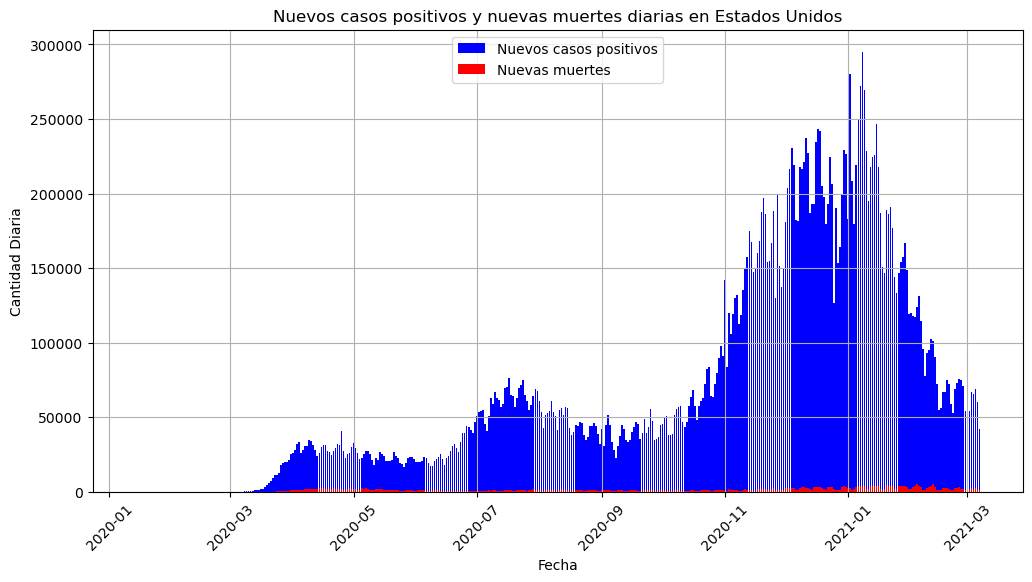

In [5]:
totales_usa['new_positive'] = totales_usa['positive'].diff()
totales_usa['new_death'] = totales_usa['death'].diff()
# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline
plt.figure(figsize=(12, 6))
# Utilizar plt.bar() en lugar de plt.plot()
plt.bar(totales_usa['date'], totales_usa['new_positive'], label='Nuevos casos positivos', color='blue')
plt.bar(totales_usa['date'], totales_usa['new_death'], label='Nuevas muertes', color='red')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Nuevos casos positivos y nuevas muertes diarias en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()
# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
%matplotlib qt

# Detalle de la obtención de datos.
Se ha creado un código para recuperar los datos de contagios y defunciones por covid 19 en Estados Unidos.
Los datos de los que se dispone se refieren al periodo entre enero de 2020 y marzo de 2021, en un total de 450 días, en todos los estados y territorios del país.

### Importación de librerías.
Empezamos importando las librerías que vamos a usar en la aplicación.
<pre>import sys
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook</pre>

### Origen de los datos.
Establecemos el origen de los datos. Podemos recuperarlos en CSV o en JSON. Aunque en la aplicación sólo usamos el formato en JSON, establecemos los dos, para tenerlos por si queremos cambiar en el futuro.
<pre>url_csv = "https://api.covidtracking.com/v1/states/daily.csv"
url_json = "https://api.covidtracking.com/v1/states/daily.json"</pre>

### Creación del DataFrame.
Creamos un DataFrame con Pandas a partir de los datos obtenidos.
<pre>hist_covid = requests.get(url_json)
awnser_code = hist_covid.status_code
if awnser_code != 200:
    print("Error en la lectura de datos.")
    sys.exit()
json_covid = hist_covid.json()
frames = pd.DataFrame(json_covid) # Obtenemos el DataFrame
#print(frames.info()) # Verificar la estructura del DataFrame
frames.fillna(0, inplace=True) # Rellenar con 0 los valores faltantes (si los hay)
frames['date'] = pd.to_datetime(frames['date'], format='%Y%m%d') # Convertir la columna de fecha al tipo de dato datetime</pre>

### Obtener datos complementarios.
A partir del DataFrame obtenemos datos complementarios que, aunque inicialmente no vayamos a usar, pueden sernos útiles en otro momento.
<pre>descripcion = frames.describe() # Datos promedio
columnas = frames.columns.tolist()</pre>

### Totales por estado y globales.
Obtenemos los totales por estado y los totales globales del pais.
<pre># Agrupar por 'state' y 'date' y sumar las columnas relevantes
totales_estado = frames.groupby(['state', 'date']).sum().reset_index()

totales_usa = frames.groupby('date').agg({
    'positive': 'sum',
    'death': 'sum',
    'recovered': 'sum',
}).reset_index()

estados_de_eeuu = totales_estado['state'].unique().tolist() # Lista de estados</pre>

### Graficas por estados.
Se obtienen las gráficas por estados. Como son 56 gráficas, no se vuelcan a pantalla, si no que se graban en imagenes png, en el directorio <code>charts</code>.
<pre>matplotlib.use('agg') # Se prepara Matplotlib para volcar los gráficos a ficheros.
# Graficos por estado
for state in estados_de_eeuu:
    # Filtrar datos para un estado específico
    state_data = totales_estado[totales_estado['state'] == state]
    # Generar la gráfica y guardarla en un archivo
    plt.figure(figsize=(12, 6))
    plt.plot(state_data['date'], state_data['positive'], label='Casos positivos')
    plt.plot(state_data['date'], state_data['death'], label='Muertes')
    plt.xlabel('Fecha')
    plt.ylabel('Cantidad')
    plt.title(f'Casos positivos y muertes en {state}')
    plt.legend()
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.savefig(f'charts/{state}_chart.png')  # Guardar las gráficas como imágenes en el directorio actual
    plt.close()  # Cerrar la figura para liberar memoria</pre>

### Gráfica global con Matplotlib
La gráfica global de todo el país en el periodo seleccionado la hemos sacado con tres herramientas. En primer lugar la hemos obtenido en pantalla con Matplotlib, con el siguiente código:
<pre>
## Gráfica para el total de Estados Unidos con Matplolib solamente
# Calcular los nuevos casos diarios y nuevas muertes diarias
totales_usa['new_positive'] = totales_usa['positive'].diff()
totales_usa['new_death'] = totales_usa['death'].diff()
matplotlib.use('TkAgg') # Se pone matplolib para sacar los gráficos en pantalla.
# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['new_positive'], label='Nuevos casos positivos', color='blue')
plt.plot(totales_usa['date'], totales_usa['new_death'], label='Nuevas muertes', color='red')
plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Nuevos casos positivos y nuevas muertes diarias en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()</pre>

### Grafica global con Seaborn
Una alternativa es utilizar Seaborn para la gráfica final.
<pre># Convertir la columna 'date' a valores numéricos (días desde el inicio de los datos)
frames['days_since_start'] = (frames['date'] - frames['date'].min()).dt.days
# Crear un gráfico de dispersión con ajuste de regresión con Seaborn
# Establecer el estilo de Seaborn
sns.set(style="whitegrid")
sns.set_palette("muted")
plt.figure(figsize=(10, 6))
sns.regplot(x='days_since_start', y='positive', data=frames, scatter_kws={'color': 'blue'}, line_kws={'color': 'red'})
plt.title('Total de casos de COVID-19 en Estados Unidos')
plt.xlabel('Días desde el inicio de los datos')
plt.ylabel('Total de casos')
plt.tight_layout()
plt.show()</pre>

### Gráfica global con Bokeh
Con Bokeh se puede obtener una gráfica con una pequeña interactividad, como ampliar una parte del gráfico, que puede visualizarse en el navegador o en un cuaderno de jupyter notebook.
<pre># Calcular la media de casos de COVID-19 para cada día
mean_cases_per_day = frames.groupby('days_since_start')['positive'].mean().reset_index()
# Calcular la media de defunciones de COVID-19 para cada día
mean_deaths_per_day = frames.groupby('days_since_start')['death'].mean().reset_index()
# Crear un gráfico de línea interactivo con Bokeh
p = figure(width=800, height=400, title='Total de casos de COVID-19 en Estados Unidos',
           x_axis_label='Días desde el inicio de los datos', y_axis_label='Media de casos')
p.line(x='days_since_start', y='positive', source=mean_cases_per_day, line_color='blue', line_width=2, legend_label='Casos registrados')
p.line(x='days_since_start', y='death', source=mean_deaths_per_day, line_color='red', line_width=2, legend_label='Defunciones')
# Agregar leyenda al gráfico
p.legend.location = "top_left"
# Habilitar la salida del gráfico en el notebook
output_notebook()
# Mostrar el gráfico interactivo en el notebook
show(p)</pre>

Si vamos a obtener la gráfica en el navegador es necesario anular la línea <code>output_notebook()</code>.

# Obtener una gráfica de los datos totales

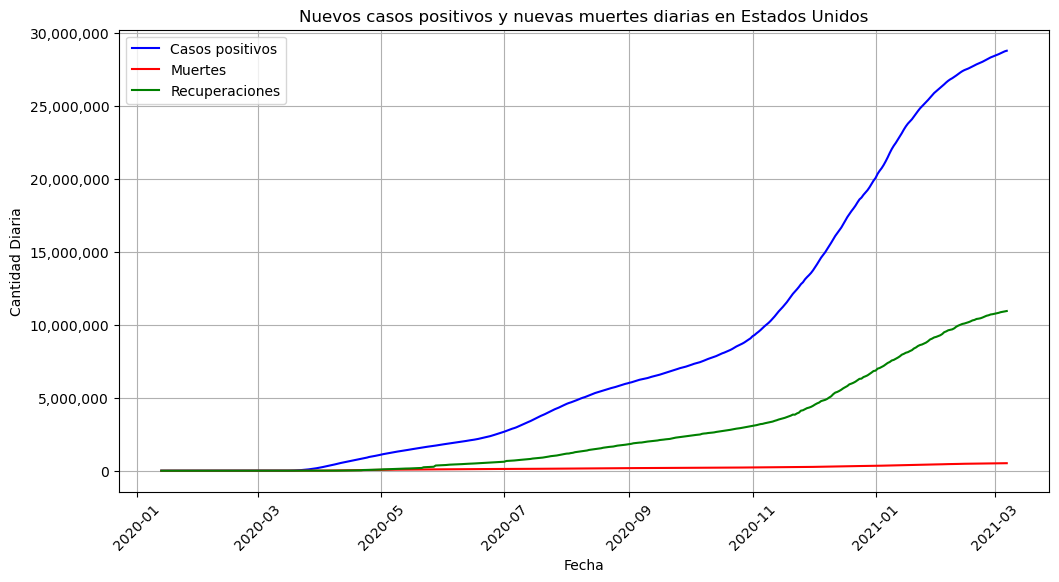

In [3]:
import sys
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import matplotlib.ticker as ticker

url_csv = "https://api.covidtracking.com/v1/states/daily.csv"
url_json = "https://api.covidtracking.com/v1/states/daily.json"

################################ OBTENER LOS DATOS Y CREAR UN DATAFRAME #################################
hist_covid = requests.get(url_json)
awnser_code = hist_covid.status_code
if awnser_code != 200:
    print("Error en la lectura de datos.")
    sys.exit()
json_covid = hist_covid.json()
frames = pd.DataFrame(json_covid) # Obtenemos el DataFrame
#print(frames.info()) # Verificar la estructura del DataFrame
frames['date'] = pd.to_datetime(frames['date'], format='%Y%m%d') # Convertir la columna de fecha al tipo de dato datetime
estadisticas = frames.describe() # Datos promedio
columnas = frames.columns.tolist()

# Total de contagios y fallecimientos en todo el pais
totales_usa = frames.groupby('date').agg({
    'positive': 'sum',
    'death': 'sum',
    'recovered': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline

# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['positive'], label='Casos positivos', color='blue')
plt.plot(totales_usa['date'], totales_usa['death'], label='Muertes', color='red')
plt.plot(totales_usa['date'], totales_usa['recovered'], label='Recuperaciones', color='green')

# Formatear el eje y con separadores de miles
ax = plt.gca()  # Obtener el eje actual
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Nuevos casos positivos y nuevas muertes diarias en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
%matplotlib qt

['date', 'state', 'positive', 'probableCases', 'negative', 'pending', 'totalTestResultsSource', 'totalTestResults', 'hospitalizedCurrently', 'hospitalizedCumulative', 'inIcuCurrently', 'inIcuCumulative', 'onVentilatorCurrently', 'onVentilatorCumulative', 'recovered', 'lastUpdateEt', 'dateModified', 'checkTimeEt', 'death', 'hospitalized', 'hospitalizedDischarged', 'dateChecked', 'totalTestsViral', 'positiveTestsViral', 'negativeTestsViral', 'positiveCasesViral', 'deathConfirmed', 'deathProbable', 'totalTestEncountersViral', 'totalTestsPeopleViral', 'totalTestsAntibody', 'positiveTestsAntibody', 'negativeTestsAntibody', 'totalTestsPeopleAntibody', 'positiveTestsPeopleAntibody', 'negativeTestsPeopleAntibody', 'totalTestsPeopleAntigen', 'positiveTestsPeopleAntigen', 'totalTestsAntigen', 'positiveTestsAntigen', 'fips', 'positiveIncrease', 'negativeIncrease', 'total', 'totalTestResultsIncrease', 'posNeg', 'dataQualityGrade', 'deathIncrease', 'hospitalizedIncrease', 'hash', 'commercialScore',

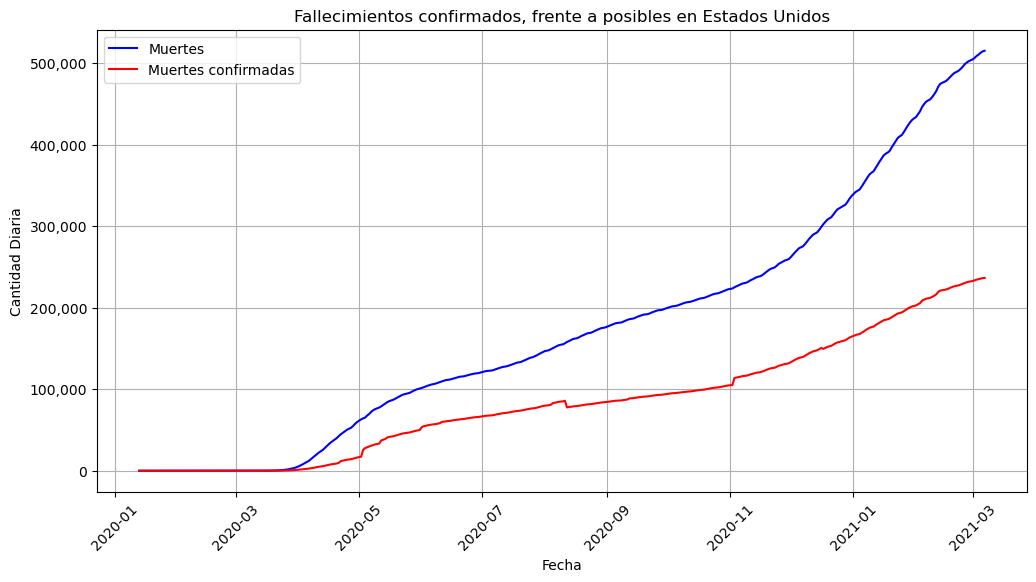

In [11]:
import sys
import requests
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns
from bokeh.plotting import figure, show
from bokeh.io import output_notebook
import matplotlib.ticker as ticker

url_csv = "https://api.covidtracking.com/v1/states/daily.csv"
url_json = "https://api.covidtracking.com/v1/states/daily.json"

################################ OBTENER LOS DATOS Y CREAR UN DATAFRAME #################################
hist_covid = requests.get(url_json)
awnser_code = hist_covid.status_code
if awnser_code != 200:
    print("Error en la lectura de datos.")
    sys.exit()
json_covid = hist_covid.json()
frames = pd.DataFrame(json_covid) # Obtenemos el DataFrame
#print(frames.info()) # Verificar la estructura del DataFrame
frames['date'] = pd.to_datetime(frames['date'], format='%Y%m%d') # Convertir la columna de fecha al tipo de dato datetime
estadisticas = frames.describe() # Datos promedio
columnas = frames.columns.tolist()

print (columnas)

# Total de contagios y fallecimientos en todo el pais
totales_usa = frames.groupby('date').agg({
    'death': 'sum',
    'deathConfirmed': 'sum',
}).reset_index()

# Hacemos que la gráfica se muestre en un cuaderno de notebook
%matplotlib inline

# Generar la gráfica.
plt.figure(figsize=(12, 6))
plt.plot(totales_usa['date'], totales_usa['death'], label='Muertes', color='blue')
plt.plot(totales_usa['date'], totales_usa['deathConfirmed'], label='Muertes confirmadas', color='red')

# Formatear el eje y con separadores de miles
ax = plt.gca()  # Obtener el eje actual
ax.yaxis.set_major_formatter(ticker.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x)))

plt.xlabel('Fecha')
plt.ylabel('Cantidad Diaria')
plt.title('Fallecimientos confirmados, frente a posibles en Estados Unidos')
plt.legend()
plt.xticks(rotation=45)
plt.grid(True)
plt.show()
plt.close()

# Desactivamos el efecto de mostrar la gráfica en un cuaderno de notebook
%matplotlib qt

# CONCLUSIONES.
De la visualización de los gráficos obtenidos, tanto por estados como global del país, se infiere que, en el perido analizado, entre enero de 2020 y marzo de 2021, se infieren las siguientes conclusiones:

- En el periodo inicial no había prácticamente casos tipificados, pero sí se registraron muertes que fueron atribuidas al covid.
- En un breve periodo de tiempo se empezaron a registrar casos de contagios, que aumentaban rápidamente. Esto refleja que las medidas de contención y aislamiento no fueron efectivas, o no tanto como habría sido deseable.
- Sin embargo, las cifras de defunciones atribuidas al covid se mantienen casi estables en el tiempo. Esto relfeja que las actividades sanitarias para curar a los enfermos fueron altamente efectivas, logrando mantener a raya los números de fallecimientos.

### En todos los gráficos, nos centramos en los valores más relevantes: las columnas <code>positive</code> (contagios positivos registrados) y <code>death</code> (fallecimientos)

Hasta los 64 días desde el inicio del periodo contemplado no empiezan a registrarse casos de contagios, o estos no constan en el archivo de datos. Probablemente, en ese periodo hubiera cierta expansión de contagios que no se han reflejado.
Sin embargo, desde el momento en que empiezan a registrarse contagios, es de suponer que se pusieron medios sanitarios para restablecer la salud de las víctimas, logrando mantener muy bajo el número de fallecimientos.

La conclusión obvia es que conocer la magnitud de la pandemia, y poner los medios adecuados, logró salvar innumerables vidas.

### Recuperaciones.
Cabría esperar que el número de recuperaciones y de fallecimientos sumaran el total de contagios, pero no es así. De esto se deduce que los datos no están completos.